In [73]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

In [208]:
class Particle(object):
    def __init__(self, x, v, fitness_value):
        self.x = x
        self.v = v
        self.fitness_value = fitness_value
        self.pbest_x = x
        self.pbest_fitness_value = fitness_value
    
    # 得到需要更新的速度
    def get_updated_velocity(self, gbest_particle, w, c1, c2, v_boundaries):
        # 将多维展开给一维 [[1, 2]] => [1, 2]
        r1, r2 = np.random.uniform(0, 1, size=(2, 1)).ravel()
        print(self.pbest_x - self.x)
        v = w * self.v + c1 * r1 * (self.pbest_x - self.x) + c2 * r2 * (gbest_particle.x - self.x)

        for i, d in enumerate(v):
            if v[i] < v_boundaries[0][i]:
                v[i] = v_boundaries[0][i]
            if v[i] > v_boundaries[1][i]:
                v[i] = v_boundaries[1][i]
        return v

    # 更新位置
    # 若更新后的位置优于历史最优，则历史最优为更新后的位置 (TODO)
    def update_position(self, gbest_particle, w, c1, c2, fitness_func, boundaries, v_boundaries):
        self.v = self.get_updated_velocity(gbest_particle, w, c1, c2, v_boundaries)
        update_x = self.x + self.v
        # 更新后的位置
        # self.x = self.x + self.v

        # 检查各分量是否越界
        for i, d in enumerate(self.x):
            if self.x[i] < boundaries[0][i]:
                self.x[i] = boundaries[0][i]
            if self.x[i] > boundaries[1][i]:
                self.x[i] = boundaries[1][i]

        fitness_value = fitness_func(update_x)
        
        # 如果新位置为当前历史最优，则将历史最优代换成当前位置
        # TODO 这里其实有一个疑问，新生成的向量优于当前向量时，是否需要进行替换
        # 如果不替换，则随机性大，最终无法收敛
        if fitness_value < self.fitness_value:
            self.x = update_x
            self.fitness_value = fitness_value
            self.pbest_x = self.x.copy()
            self.pbest_fitness_value = self.fitness_value

In [209]:
class Param(object):
    def __init__(self, param_range, T):
        self.param_range = param_range
        self.t = 0
        self.T = T

    def next(self):
        self.t += 1
        return self.param_range[0] + (self.param_range[1] - self.param_range[0]) * (2 - math.exp((self.t / self.T) * math.log(2)))

In [210]:
class PSO(object):
    def __init__(self, N, D, boundaries, v_boundaries, fitness_func, epoch, w, c1, c2, hooks):
        np.random.seed()
        self.N = N
        self.D = D
        self.boundaries = boundaries
        self.v_boundaries = v_boundaries
        self.fitness_func = fitness_func
        self.gbest_index = 0
        self.epoch = epoch
        self.particles = []
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.hooks = hooks
        self.initialize()
    
    def initialize(self):
        # np.random.rand() => [0, 1)
        positions = [self.boundaries[0] +  np.matmul(np.diag(np.random.rand(self.D)), self.boundaries[1] - self.boundaries[0]) for _ in range(self.N)]
        velocities = [self.v_boundaries[0] + np.matmul(np.diag(np.random.rand(self.D)), self.v_boundaries[1] - self.v_boundaries[0]) for _ in range(self.N)]
        fitness_values = [self.fitness_func(position) for position in positions]
        self.particles = [Particle(positions[i], velocities[i], fitness_values[i]) for i in range(self.N)]
        self.update_gbest()
    
    def update_gbest(self):
        self.gbest_index = 0
        for i in range(1, self.N):
            if self.particles[i].fitness_value < self.particles[self.gbest_index].fitness_value:
                self.gbest_index = i

    def fit(self):
        for _ in range(self.epoch):
            best_particle = self.particles[self.gbest_index]
            w = self.w.next()
            c1 = self.c1.next()
            c2 = self.c2.next()
            # print(w, c1, c2)

            for i in range(self.N):
                self.particles[i].update_position(best_particle, w, c1, c2, self.fitness_func, self.boundaries, self.v_boundaries)

            self.update_gbest()
            # print(self.particles[self.gbest_index].fitness_value)
            self.hooks['record_gbest_particle'](self.particles[self.gbest_index])

    def get_gbest_particle(self):
        return self.particles[self.gbest_index]

In [215]:
N = 60
D = 10
boundaries = np.array([[-100] * D, [100] * D])
v_boundaries = np.array([[-100] * D, [100] * D])
epoch = 2000
w = Param([0, 0.8], epoch)
c1 = Param([0, 0.5], epoch)
c2 = Param([0, 0.8], epoch)


def cost_func(xs):
    return sum(xs[:2]) + sum([x**2 for x in xs[2:]])

In [216]:
best_fitness_values = []
def record_gbest_particle(particle):
    global best_fitness_values
    best_fitness_values.append(particle.fitness_value)

In [222]:
pso = PSO(
    N=N,
    D=D,
    boundaries=boundaries, 
    v_boundaries=v_boundaries, 
    fitness_func=cost_func,
    epoch=epoch,
    w=w,
    c1=c1,
    c2=c2,
    hooks={'record_gbest_particle': record_gbest_particle}
    )

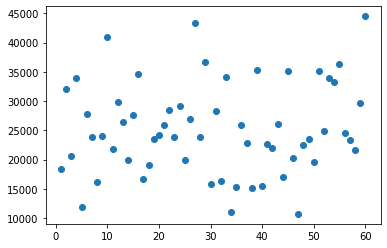

[18358.12474574733, 32023.796931186407, 20678.754757755414, 33947.98285744563, 11911.323440193542, 27785.854032342282, 23843.6565258393, 16237.782671462266, 24003.001735627586, 40994.21738748817, 21870.271994994026, 29858.69086102013, 26393.333550904754, 19867.085738075446, 27679.20087113596, 34675.50123688624, 16751.756237749134, 19117.23012646282, 23540.36157257844, 24163.711238246808, 25924.32435812708, 28450.571141764696, 23914.61882064382, 29239.55447782864, 20003.72816799358, 26956.48225852023, 43324.71249718524, 23898.24863754601, 36690.330702136256, 15784.003336155, 28243.716417168165, 16384.81835065016, 34162.358929147485, 10982.943096456263, 15315.217279976492, 25860.695015258276, 22894.064175454412, 15107.607723399278, 35388.233991424, 15550.282772107428, 22726.308925852187, 22049.27937577324, 26028.32640362944, 17103.646549679557, 35138.202366717924, 20226.49702368233, 10714.449357633564, 22430.970128460598, 23519.448093270115, 19646.52051241035, 35225.81952253026, 24884.93

In [223]:
# 初始时得到的散点图
plt.scatter(np.arange(1, N + 1), [particle.fitness_value for particle in pso.particles])
plt.show()
print([particle.fitness_value for particle in pso.particles])
print(pso.get_gbest_particle().fitness_value)

In [219]:
pso.fit()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0

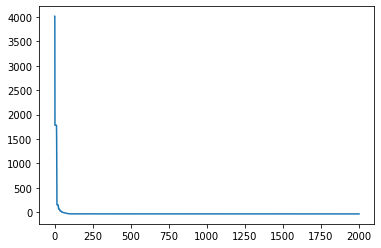

250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.547948045250635, -34.5

In [220]:
plt.plot(np.arange(1, epoch + 1), best_fitness_values)
plt.show()
# print(len(best_fitness_values))
print(best_fitness_values)

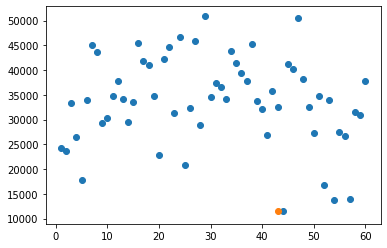

In [187]:
# 初始时得到的散点图
plt.scatter(np.arange(1, N + 1), [particle.fitness_value for particle in pso.particles])
plt.scatter([pso.gbest_index], [pso.get_gbest_particle().fitness_value])
plt.show()

In [9]:
r1, r2 = np.random.rand(1, 2).ravel()

print(r1, r2)

0.4272084981401857 0.4807483638244925


In [146]:
np.random.rand()
np.arange(1, epoch + 1)

array([   1,    2,    3, ..., 1998, 1999, 2000])

In [28]:
np.diag(np.random.rand(4))

array([[0.55488198, 0.        , 0.        , 0.        ],
       [0.        , 0.1716563 , 0.        , 0.        ],
       [0.        , 0.        , 0.64985943, 0.        ],
       [0.        , 0.        , 0.        , 0.07167347]])